In [1]:
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import torch
import torch.nn as nn
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from IPython.display import clear_output
import hyperopt
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import math

In [3]:
with open('data_train_dict_torch.pkl', 'rb') as f:
    data_train = pickle.load(f)

with open('data_test_dict_torch.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [4]:
min_channels = []
max_channels = []
train_dims = [100, 120, 140, 160, 180]
for we, sn in np.random.permutation([*product(train_dims, train_dims)]):
    min_channels.append(data_train[f'{we}x{sn}'].transpose(0, 1).reshape(15, -1).min(dim=1)[0])
    max_channels.append(data_train[f'{we}x{sn}'].transpose(0, 1).reshape(15, -1).max(dim=1)[0])
min_scale = torch.stack(min_channels).min(dim=0)[0]
max_scale = torch.stack(max_channels).max(dim=0)[0]

In [5]:
def scale_batch(batch, min_scale, max_scale):
    min = min_scale[None,...,None, None].to(batch.device)
    max = max_scale[None,...,None, None].to(batch.device)
    return (batch - min) / (max - min)

In [6]:
def iterate_minibatches(*tensors, batch_size, shuffle=True, epochs=1,
                        allow_incomplete=True, callback=lambda x:x):
    indices = np.arange(len(tensors[0]))
    upper_bound = int((np.ceil if allow_incomplete else np.floor) (len(indices) / batch_size)) * batch_size
    epoch = 0
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for batch_start in callback(range(0, upper_bound, batch_size)):
            batch_ix = indices[batch_start: batch_start + batch_size]
            batch = [tensor[batch_ix] for tensor in tensors]
            yield batch if len(tensors) > 1 else batch[0]
        epoch += 1
        if epoch >= epochs:
            break

# bayesian

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels=15, 
                    conv_kernel_0 = 3, adaptive_size = 90, 
                    conv_kernel_1 = 3, pool_kernel_1 = 2, pool_stride_1 = 2, 
                    conv_kernel_2 = 3, pool_kernel_2 = 2, pool_stride_2 = 2,
                    conv_kernel_3 = 3, pool_kernel_3 = 2, pool_stride_3 = 2,
                    upsample_1 = 16,
                    upsample_2 = 24,
                    upsample_3 = 52):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=15, kernel_size=conv_kernel_0),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(adaptive_size, adaptive_size)), 
            
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=conv_kernel_1),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_1, stride=pool_stride_1), # a = math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1

            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=conv_kernel_2),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_2, stride=pool_stride_2), # b = math.ceil((a - (conv_kernel_2 - 1)) / pool_stride_2) - 1

            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=conv_kernel_3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_3, stride=pool_stride_3), # c = math.ceil((b - (conv_kernel_3 - 1)) / pool_stride_3) - 1

            nn.Flatten(),
        )
        self.encoder = self.encoder.float() # c = math.ceil((math.ceil((math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1 - (conv_kernel_2 - 1)) / pool_stride_2) - 1 - (conv_kernel_3 - 1)) / pool_stride_3) - 1

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (10, 1 + int(math.ceil((math.ceil((math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1 - (conv_kernel_2 - 1)) / pool_stride_2) - 1 - (conv_kernel_3 - 1)) / pool_stride_3) - 1), 
                            1 + int(math.ceil((math.ceil((math.ceil((adaptive_size - (conv_kernel_1 - 1)) / pool_stride_1) - 1 - (conv_kernel_2 - 1)) / pool_stride_2) - 1 - (conv_kernel_3 - 1)) / pool_stride_3) - 1))),
            
            nn.ConvTranspose2d(in_channels=10, out_channels=10, kernel_size=conv_kernel_3),
            nn.Upsample(size=(upsample_1, upsample_1)),
            nn.ConvTranspose2d(in_channels=10, out_channels=15, kernel_size=conv_kernel_2),
            nn.Upsample(size=(upsample_2, upsample_2)),
            nn.ConvTranspose2d(in_channels=15, out_channels=15, kernel_size=conv_kernel_1),
            nn.Upsample(size=(upsample_3, upsample_3)),
            nn.ConvTranspose2d(in_channels=15, out_channels=15, kernel_size=conv_kernel_0),
        )
        self.decoder = self.decoder.float()

    def forward(self, features):
        emb = self.encoder(features)
        reconstructed = self.decoder(emb)
    
        _, _, w, h = features.shape
        reconstructed = nn.Upsample(size=(w, h))(reconstructed)
    
        if reconstructed.shape != features.shape:
            print(reconstructed.shape)
            print(features.shape)
            assert False
    
        return reconstructed

In [73]:
def objective(params):
    device = 'cuda'
    print(params)

    model = Autoencoder(conv_kernel_0 = int(params['conv_kernel_0']), 
                        adaptive_size = int(params['adaptive_size']), 
                        conv_kernel_1 = int(params['conv_kernel_1']), 
                        # pool_kernel_1 = int(params['pool_kernel_1']), 
                        # pool_stride_1 = int(params['pool_stride_1']),

                        conv_kernel_2 = int(params['conv_kernel_2']), 
                        # pool_kernel_2 = int(params['pool_kernel_2']), 
                        # pool_stride_2 = int(params['pool_stride_2']),

                        conv_kernel_3 = int(params['conv_kernel_3']), 
                        # pool_kernel_3 = int(params['pool_kernel_3']), 
                        # pool_stride_3 = int(params['pool_stride_3']), 

                        upsample_1 = int(params['upsample_1']),
                        upsample_2 = int(params['upsample_2']),
                        upsample_3 = int(params['upsample_3'])).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    test_loss = defaultdict(list)
    for epoch in range(5):
        for we, sn in np.random.permutation([*product(train_dims, train_dims)]):
            for batch in iterate_minibatches(data_train[f'{we}x{sn}'], batch_size=40):
                opt.zero_grad()
                batch = scale_batch(batch.to(device), min_scale, max_scale)
                out = model(batch)
                loss = criterion(out, batch)
                loss.backward()
                opt.step()
        for we, sn in [*product(train_dims, train_dims)]:
            test_batch = scale_batch(data_test[f'{we}x{sn}'].to(device), min_scale, max_scale)
            out = model(test_batch)
            test_loss[f'{we}x{sn}'].append(criterion(out, test_batch).item())
        mse_test = np.array([np.array(test_loss[f'{we}x{sn}']) for we, sn in [*product(train_dims, train_dims)]]).mean(0)
        # return mse_test[-1]
    return {'loss': mse_test[-1], 'params': params, 'status': STATUS_OK}
        

In [74]:
# possible values of parameters
space={'conv_kernel_0' : hp.choice('conv_kernel_0', [3, 5, 7]), 
        'adaptive_size' : hp.choice('adaptive_size', [60, 70, 80, 90, 100]),

        'conv_kernel_1' : hp.choice('conv_kernel_1', [3, 5, 7]), 
        # 'pool_kernel_1' : hp.quniform('pool_kernel_1', 3, 7, 2), 
        # 'pool_stride_1' : hp.quniform('pool_stride_1', 2, 2, 1),

        'conv_kernel_2' : hp.choice('conv_kernel_2', [3, 5, 7]), 
        # 'pool_kernel_2' : hp.quniform('pool_kernel_2', 3, 7, 2), 
        # 'pool_stride_2' : hp.quniform('pool_stride_2', 2, 2, 1),

        'conv_kernel_3' : hp.choice('conv_kernel_3', [3, 5, 7]), 
        # 'pool_kernel_3' : hp.quniform('pool_kernel_3', 3, 7, 2), 
        # 'pool_stride_3' : hp.quniform('pool_stride_3', 2, 2, 1),

        'upsample_1' : hp.choice('upsample_1', [12, 16, 20]),
        'upsample_2' : hp.choice('upsample_2', [26, 30, 34]),
        'upsample_3' : hp.choice('upsample_3', [42, 46, 50, 54, 56, 60])
      }

trials = Trials()

max_evals = 20
for i in range(1, max_evals + 1, 1):
    best=fmin(fn=objective,
          space=space, 
          algo=tpe.suggest,
          max_evals=i,
          trials=trials,
          show_progressbar=True
         )
    print(best)

    pickle.dump(trials, open("bayesian_results_for_kernels.pkl", "wb"))

{'adaptive_size': 80, 'conv_kernel_0': 7, 'conv_kernel_1': 5, 'conv_kernel_2': 5, 'conv_kernel_3': 7, 'upsample_1': 20, 'upsample_2': 34, 'upsample_3': 60}
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 1/1 [27:34<00:00, 1654.77s/trial, best loss: 0.0272956932336092]
{'adaptive_size': 2, 'conv_kernel_0': 2, 'conv_kernel_1': 1, 'conv_kernel_2': 1, 'conv_kernel_3': 2, 'upsample_1': 2, 'upsample_2': 2, 'upsample_3': 5}
{'adaptive_size': 90, 'conv_kernel_0': 7, 'conv_kernel_1': 3, 'conv_kernel_2': 3, 'conv_kernel_3': 3, 'upsample_1': 16, 'upsample_2': 30, 'upsample_3': 56}
100%|██████████| 2/2 [24:45<00:00, 1485.02s/trial, best loss: 0.021699546724557876]
{'adaptive_size': 3, 'conv_kernel_0': 2, 'conv_kernel_1': 0, 'conv_kernel_2': 0, 'conv_kernel_3': 0, 'upsample_1': 1, 'upsample_2': 1, 'upsample_3': 4}
{'adaptive_size': 80, 'conv_kernel_0': 5, 'conv_kernel_1': 3, 'conv_kernel_2': 7, 'conv_kernel_3': 7, 'upsample_1': 16, 'upsample_2': 30, 'upsample_3': 60}
100%|██████████| 3/3 [22:45<00:00, 1365.85s/trial, best loss: 0.021699546724557876]
{'adaptive_size': 3, 'conv_kernel_0': 2, 'conv_kernel_1': 0, 'conv_kernel_2': 0, 'conv_kernel_3': 0, 'upsample_1': 1, 'upsample_2': 1,

In [70]:
iter_done = len(trials.results)
max_evals = 10
iter_done

10

In [ ]:
for i in range(1 + iter_done, max_evals + 1 + iter_done, 1):
    best=fmin(fn=objective,
          space=space, 
          algo=tpe.suggest,
          max_evals=i,
          trials=trials,
          show_progressbar=True
         )
    print(best)
    pickle.dump(trials, open("bayesian_results_for_kernels.pkl", "wb"))

In [ ]:
trials.results

{'adaptive_pooling_size': 77.0, 'dec_first': 18.0, 'dec_second': 30.0, 'dec_third': 42.0, 'first_layer': 10.0, 'second_layer': 7.0, 'third_layer': 3.0}
loss {'loss': 0.024216577410697937, 'status': 'ok'},

In [122]:
def df_results(hp_results):
    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.sort_values(by=['loss'], ascending=False, inplace=True)
    return results

results = df_results(trials.results)

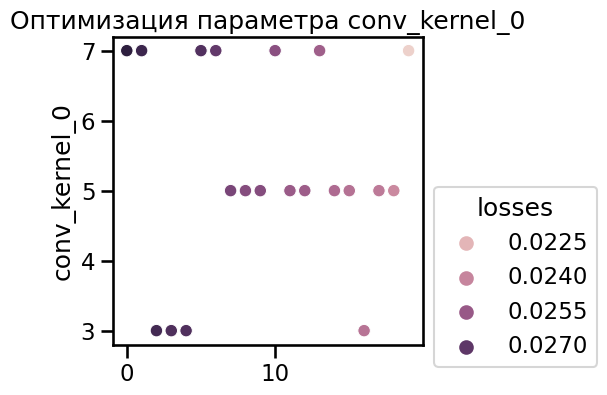

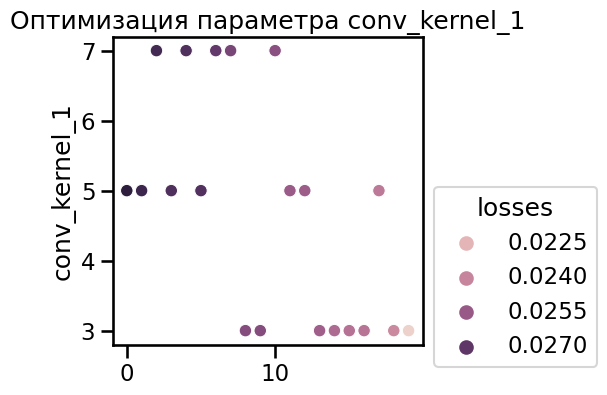

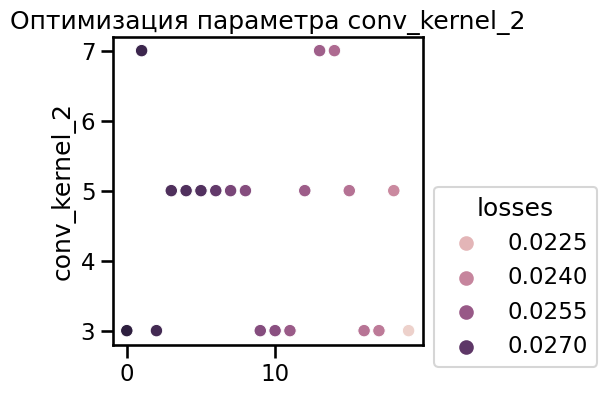

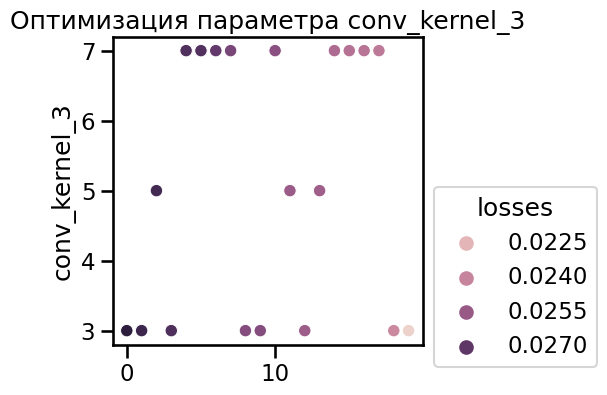

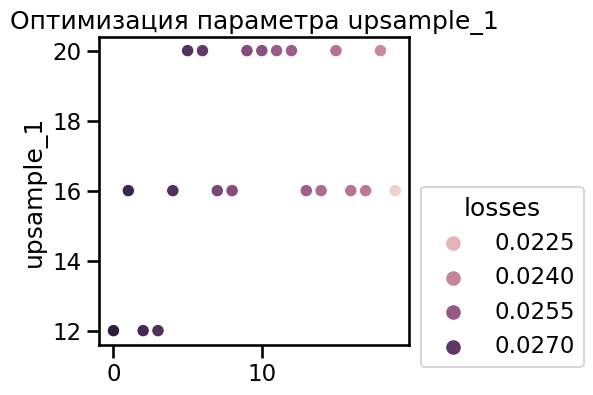

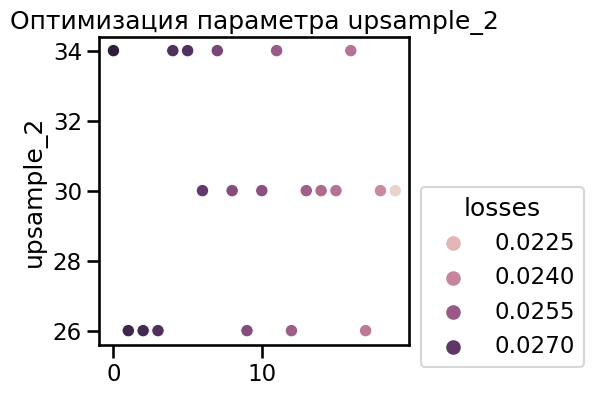

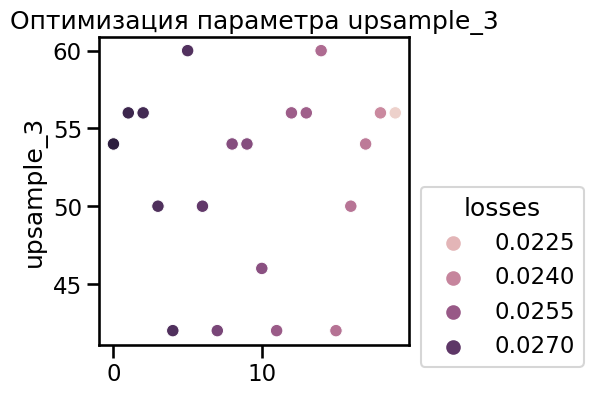

In [123]:
parameters = ['conv_kernel_0', 'conv_kernel_1', 'conv_kernel_2', 'conv_kernel_3', 'upsample_1', 'upsample_2', 'upsample_3']
for i in range(len(parameters)):
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=np.arange(0, 20), y=parameters[i], hue='loss', data=results, legend='brief')
    plt.title(f'Оптимизация параметра {parameters[i]}')
    plt.legend(loc='upper left', bbox_to_anchor = (1, .55), title='losses')
    # plt.savefig(f'bayesian_{parameters[i]}')
# plt.tight_layout()

In [125]:
best_params = {'adaptive_size': 90,
 'conv_kernel_0': 7,
 'conv_kernel_1': 3,
 'conv_kernel_2': 3,
 'conv_kernel_3': 3,
 'upsample_1': 16,
 'upsample_2': 30,
 'upsample_3': 56}

# обучение лучшей модели

In [9]:
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import torch
import torch.nn as nn
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from IPython.display import clear_output

In [10]:
device = 'cuda'
model = Autoencoder(adaptive_size=90, conv_kernel_0=7, conv_kernel_1=3, conv_kernel_2=3, conv_kernel_3=3, upsample_1=16, upsample_2=30, upsample_3=56).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [11]:
losses = []
test_loss = defaultdict(list)
penalty = 0
min_loss = 10

In [12]:
def learn(penalty, min_loss, visualize=True, iterations = 100):
    for epoch in trange(iterations):
        loss_tmp = []
        for we, sn in np.random.permutation([*product(train_dims, train_dims)]):
            for batch in iterate_minibatches(data_train[f'{we}x{sn}'], batch_size=40):
                opt.zero_grad()
                batch = scale_batch(batch.to(device), min_scale, max_scale)
                out = model(batch)
                loss = criterion(out, batch)
                loss.backward()
                opt.step()
                loss_tmp.append(loss.item())
        losses.append(np.mean(loss_tmp))
        for we, sn in [*product(train_dims, train_dims)]:
            test_batch = scale_batch(data_test[f'{we}x{sn}'].to(device), min_scale, max_scale)
            out = model(test_batch)
            test_loss[f'{we}x{sn}'].append(criterion(out, test_batch).item())
        if visualize:
            clear_output(True)
            plt.figure(figsize=[18, 6])
            plt.plot(losses, label='train')
            mse_test = np.array([np.array(test_loss[f'{we}x{sn}']) for we, sn in [*product(train_dims, train_dims)]]).mean(0)
            plt.plot(mse_test, label='test')

            if (mse_test[-1] > min_loss) or math.isclose(mse_test[-1], min_loss, rel_tol=0.005):
                penalty += 1
                if penalty > 15:
                    break
            elif mse_test[-1] < min_loss:
                torch.save(model.state_dict(), 'bayesian_model_weights.pth')
                min_loss = mse_test[-1]
                penalty = 0
            plt.grid()
            plt.legend()
            plt.show()
    return (penalty, min_loss) 

In [ ]:
punish, min_loss = learn(penalty, min_loss, True, 6)

In [22]:
print(f'min_loss: {min_loss}')
print(f'epochs_total: {losses.__len__()}')

min_loss: 0.012248981967568398
min_loss_val: 0.011980703100562096
epochs_total: 200


In [ ]:
l_arr = np.array([np.array(test_loss[f'{we}x{sn}']) for we, sn in [*product(train_dims, train_dims)]]).mean(0)
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, l_arr.shape[0] + 1), losses, color='b')
plt.title("Loss")
plt.grid()
plt.xlabel("iterations")

plt.subplot(2, 1, 2)
plt.xlabel("iterations")
plt.grid()
plt.plot(np.arange(1, l_arr.shape[0] + 1), l_arr, color='b')
plt.title("MSE")

plt.tight_layout()
# plt.savefig("bayesian_mse_ans_loss")

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(20, 10), sharex=True, sharey=True)
for i in range(5):
    for j in range(5):
        for we, sn in [*product(train_dims, train_dims)]:
            axes[i, j].plot(np.arange(1, l_arr.shape[0] + 1), np.array(test_loss[f'{we}x{sn}']), color='lightgray')
        axes[i, j].grid()
        axes[i, j].plot(np.arange(1, l_arr.shape[0] + 1), np.array(test_loss[f'{train_dims[i]}x{train_dims[j]}']), color='b')
        axes[i, j].set_title(f"{train_dims[i]}x{train_dims[j]}")
fig.suptitle("Loss на тестовом датасете в зависимости от размера выбранного домена", fontsize=20)
fig.align_xlabels()
plt.tight_layout()

# plt.savefig("bayesian_loss_sep_sizes") 

In [26]:
arr = np.array([np.array(test_loss[f'{we}x{sn}'])[-1] for we, sn in [*product(train_dims, train_dims)]])
arr.resize((5, 5))
arr = arr[::-1, ::]

In [ ]:
ar = pd.DataFrame(data=arr, index=train_dims[::-1], columns=train_dims)
ar
sns.heatmap(ar, annot=True, cmap="crest")
plt.title('''Loss на тренировочном датасете, полученный при минимальном значении потерь
          при различных размерах доменов''')
plt.xlabel("width")
plt.ylabel("height")
plt.tight_layout()
plt.savefig("bayesian_heatmap")